In [18]:
import numpy as np
import cv2
import pickle
import os

import matplotlib.pyplot as plt
from time import time

# Function to load CIFAR-10 dataset
def load_cifar10_from_directory(directory):
    def load_batch(batch_file):
        with open(batch_file, 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        return images, labels

    # Load training data
    x_train, y_train = [], []
    for i in range(1, 6):
        batch_file = os.path.join(directory, f"data_batch_{i}")
        images, labels = load_batch(batch_file)
        x_train.append(images)
        y_train.append(labels)
    
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Load test data
    x_test, y_test = load_batch(os.path.join(directory, "test_batch"))
    
    # Reshape the data
    x_train = x_train.reshape(x_train.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
    x_test = x_test.reshape(x_test.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
    return (x_train, np.array(y_train)), (x_test, np.array(y_test))

# Load CIFAR-10 dataset
directory = '/root/jupyter_notebooks/Group10_EAI_Project/cifar-10-batches-py/'
(x_train, y_train), (x_test, y_test) = load_cifar10_from_directory(directory)

# Normalize the images
x_test_norm = (x_test / 255.0).astype("float32")

x_train_norm = (x_train / 255.0).astype('float32')


In [19]:
from pynq_dpu import DpuOverlay
# Load DPU overlay
overlay = DpuOverlay("dpu.bit")
#overlay = DpuOverlay("/root/jupyter_notebooks/Group10_EAI_Project/dpu.bit")
overlay.load_model("/root/jupyter_notebooks/Group10_EAI_Project/xmodels/87LITE.xmodel")
dpu = overlay.runner

# Get input and output tensor details
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

# Prepare input and output arrays
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32,order = "C")]
# image = input_data[0]

# Define a proper softmax function
def getSoftmax(x):
    exp_x = np.exp(x - np.max(x))  # Stability improvement
    return exp_x / exp_x.sum()


Started inference on sample images...
Completed inference.


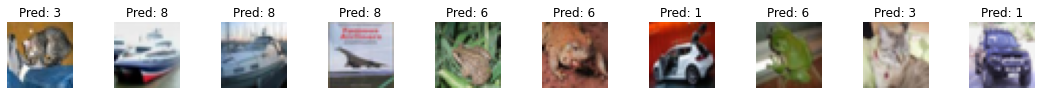

In [20]:
# Try inference on a few pictures
import matplotlib.pyplot as plt
%matplotlib inline

# Number of test images to visualize
N = 10

# # Create an empty array to hold the input data in the correct format (for RGB images)
# # Assuming the DPU input requires a batch size of 1
# image[0,....] = np.zeros((1, 32, 32, 3), dtype=np.float32)  # Input format: (1, 32, 32, 3)
image = np.zeros((1, 32, 32, 3), dtype=np.float32)  # Shape: (batch_size, height, width, channels)


# Prepare the figure for displaying results
fig, ax = plt.subplots(1, N, figsize=(15, 5))  # Adjust layout for better visibility
plt.tight_layout()

print("Started inference on sample images...")

for i in range(N):
    image[0, ...] = x_test_norm[i]  # Normalized RGB image (32, 32, 3)

    # Prepare input_data as required by the DPU runner
    input_data = [image]
    # Send the image input to the DPU
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)

    # Process the output and apply softmax
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = getSoftmax(temp[0][0])

    # Get the predicted label
    pred = softmax.argmax()

    # Display the image with its prediction
    ax[i].imshow(x_test[i])  # Display the original (unnormalized) image
    ax[i].set_title(f'Pred: {pred}')
    ax[i].axis('off')

print("Completed inference.")
plt.show()




In [21]:
from time import time
N = x_test_norm.shape[0]  # Use x_test_norm for RGB images
y_pred = np.empty_like(y_test)

# Create an empty array to hold the input data in the correct format (for RGB images)
# Assuming the DPU input requires a batch size of 1
image = np.zeros((1, 32, 32, 3), dtype=np.float32)  # Change shape to (1, 32, 32, 3)

# Start measuring execution time
start = time()
print("Started")

# Run inference on DPU KRIA SOM
for i in range(N):
    image[0, ...] = x_test_norm[i]  # Normalized RGB image (32, 32, 3)

    # Prepare input_data as required by the DPU runner
    input_data = [image]
    # Send the image input to the DPU
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # Process the output and apply softmax
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = getSoftmax(temp[0][0])
    
    # Get the predicted label
    y_pred[i] = softmax.argmax()

# Stop measuring time
stop = time()
print("Stopped")
    

# Calculate metrics
correct = np.sum(y_pred == y_test)
acc = correct / N * 100
exec_time = stop - start
print(f"Accuracy: {acc:.2f}%")
print(f"Execution time: {exec_time:.2f} seconds")
print(f"Throughput: {N / exec_time:.2f} FPS")


Started
Stopped
Accuracy: 86.68%
Execution time: 7.78 seconds
Throughput: 1284.58 FPS


In [10]:
del overlay
del dpu